In [1]:
import h5py, sys, os
import numpy as np
from scipy import ndimage
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation
from datetime import datetime
from matplotlib import colors
print(os.getcwd())

# PyDMD imports
from pydmd import MrDMD, FbDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D, plot_eigs_mrdmd

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/wide/N_175/


In [2]:
#Load simulation data
w, b, phi, times = load_data('w_xz', 'th1_xz', 'th2_xz')
b -= b[0] # subtract initial profile so b is perturbation b
NSAMP = len(times)

print(w.shape)

times, t0_idx = calibrate_time(save_dir, times)

tstart_idx = get_index(10, times)
tend_idx = get_index(20, times)

#zplot = 0.4
zmin = 0.15
zmax = 0.4
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)

phi_contour = 1e-3
xlims = (0.2, 0.8)
clim = 1e-3

# Choose data window
w = w[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
b = b[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
phi = phi[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
times = times[tstart_idx:tend_idx+1]

# Filter out timesteps
print(len(times))
filter_step = 2
times = times[::filter_step]
ntimes = len(times)
print(len(times))

snapshots = [w[::filter_step][i] for i in range(len(times))]
phi_snapshots = [phi[::filter_step][i] for i in range(len(times))]
print(len(snapshots))

X, Y = np.meshgrid(gx, gz[zmin_idx-1:zmax_idx+1])
Xf, Yf = np.meshgrid(gxf, gzf[zmin_idx:zmax_idx+1])

Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
(211, 257, 512)
Plume penetration occured at t=2.7306
101
51
51


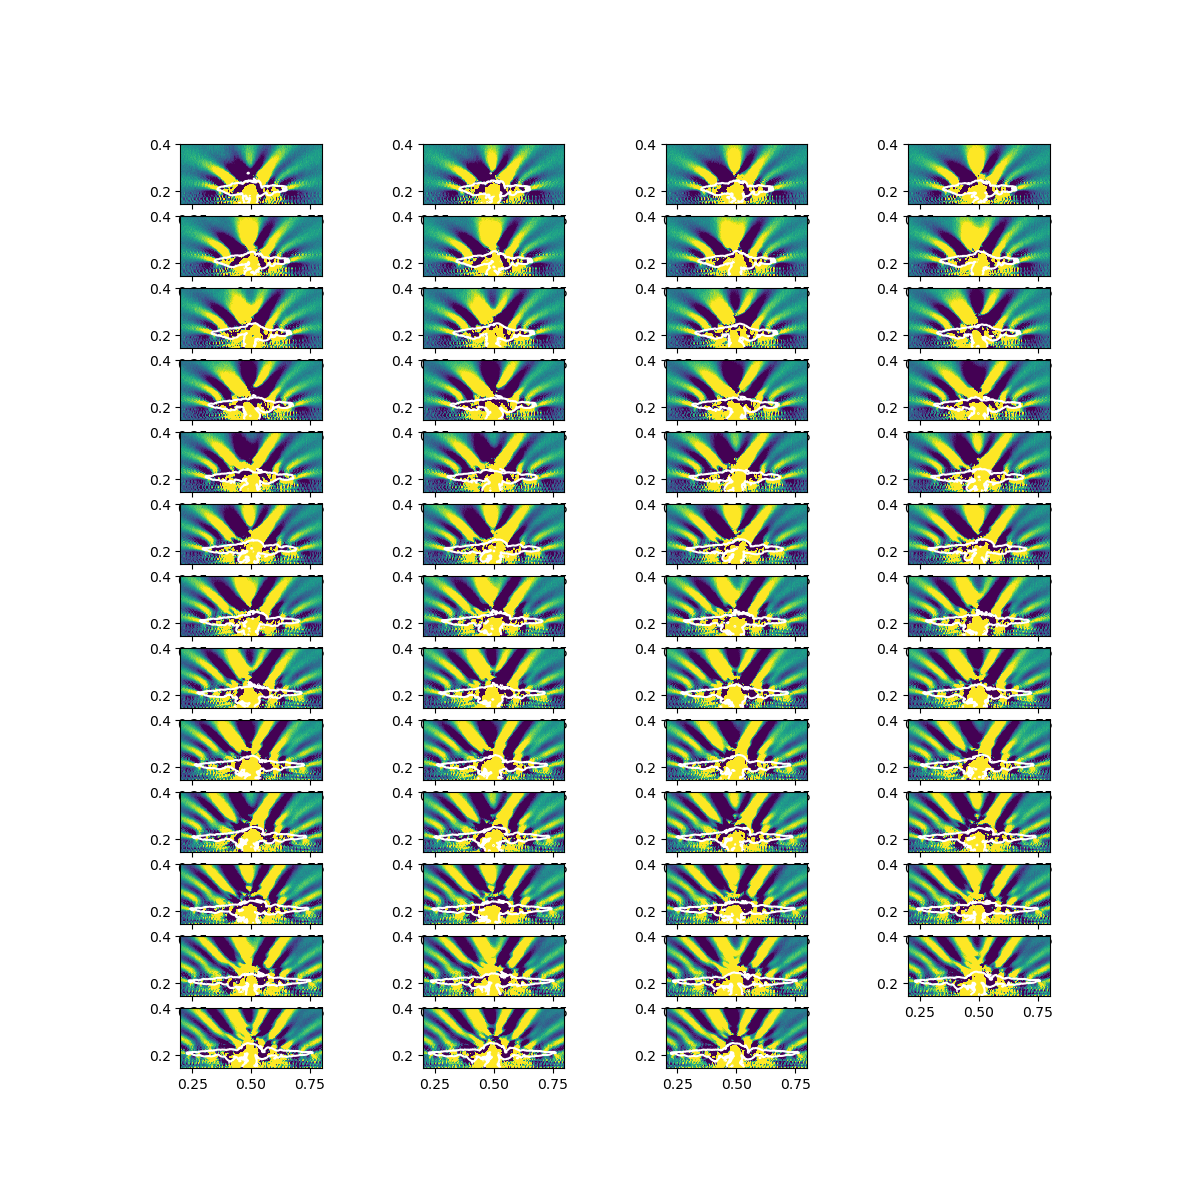

In [3]:
fig = plt.figure(figsize=(12,12))
ncol = 4
if len(snapshots) % ncol != 0:
    rnum = len(snapshots)//ncol + 1
else:
    rnum = len(snapshots)//ncol
    
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(rnum, ncol, id_subplot)
    plt.pcolormesh(X, Y, snapshot, vmin=-clim, vmax=clim)
    plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='w')
    plt.xlim(*xlims)
    plt.gca().set_aspect(1)

In [4]:
sub_dmd = FbDMD(exact=True, svd_rank=4)
dmd = MrDMD(sub_dmd, max_level=2, max_cycles=1)
dmd.fit(snapshots)

/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/pydmd/mrdmd.py:495: ComplexWarning: Casting complex values to real discards the imaginary part
  ).astype(X.dtype)


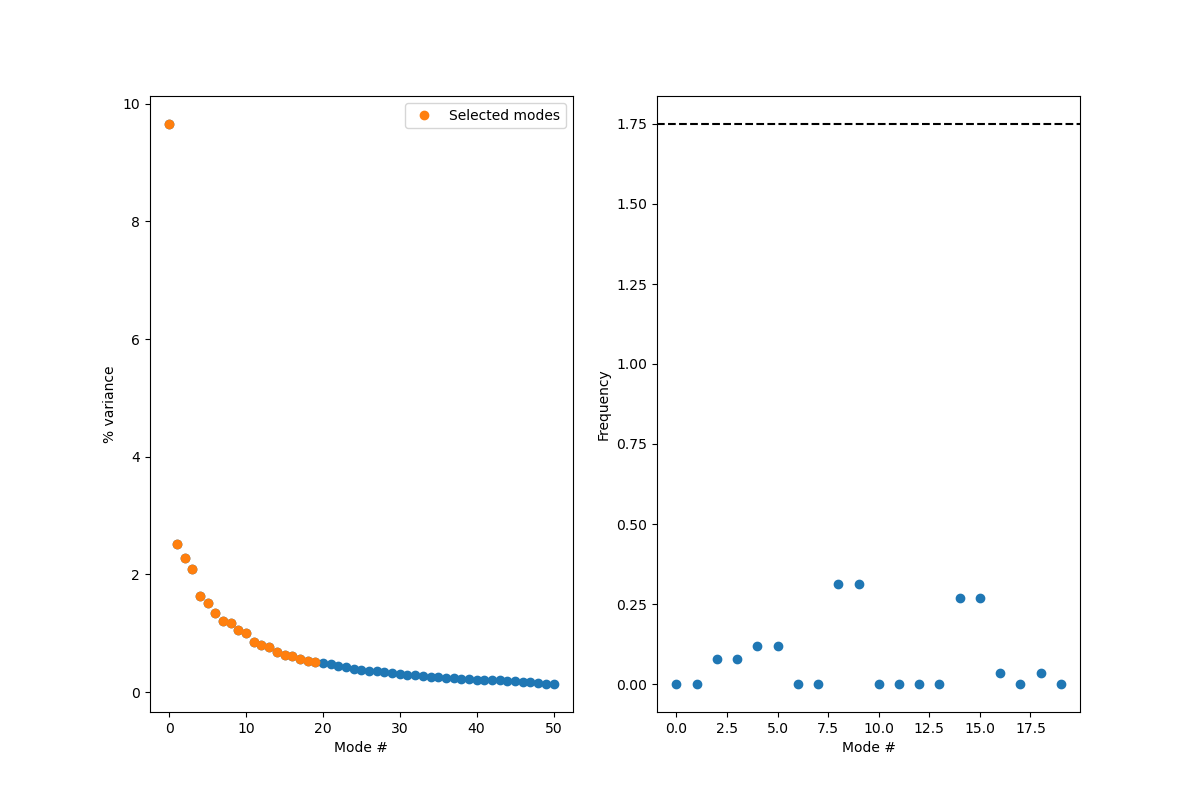

In [5]:
fig3, ax3 = plt.subplots(1,2, figsize=(12, 8))
ax3[1].plot(np.abs(dmd.frequency/(filter_step*md['SAVE_STATS_DT_FINE'])), "o")
ax3[1].set_xlabel("Mode #")
ax3[1].set_ylabel("Frequency")
ax3[1].axhline(np.sqrt(md['N2']), color='k', linestyle='--')

ax3[0].set_ylabel("% variance")
ax3[0].set_xlabel("Mode #")
ax3[0].plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T), "o")
ax3[0].plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T)[:len(dmd.eigs)], "o", label="Selected modes")
ax3[0].legend()
plt.show()

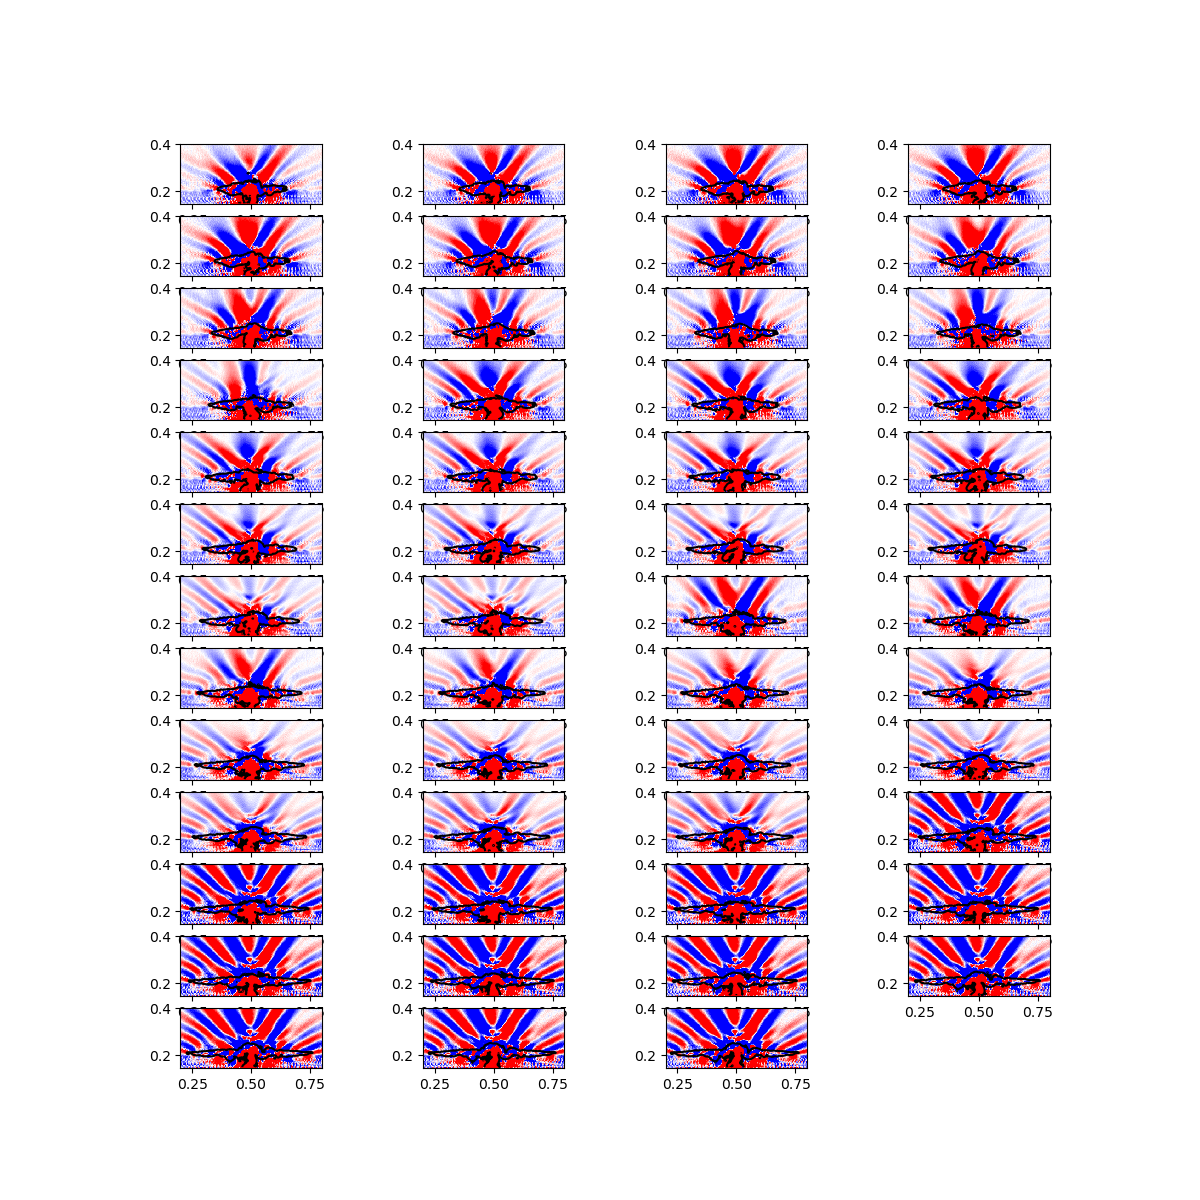

In [6]:
fig4 = plt.figure(figsize=(12, 12))
for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T, start=1):
    plt.subplot(rnum, ncol, id_subplot)
    plt.pcolormesh(
        X, Y, snapshot.reshape(w[0].shape).real, vmin=-clim, vmax=clim,
        cmap='bwr'
    )
    plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='k')
    plt.xlim(*xlims)
    plt.gca().set_aspect(1)

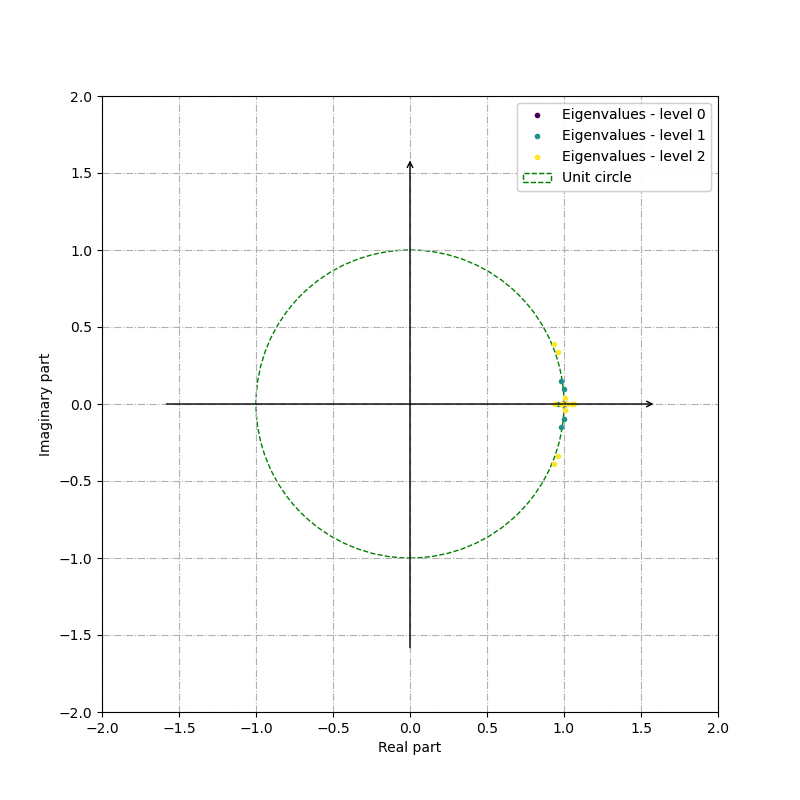

In [7]:
#plot_eigs(dmd, figsize=(8, 8))
plot_eigs_mrdmd(dmd, figsize=(8, 8))

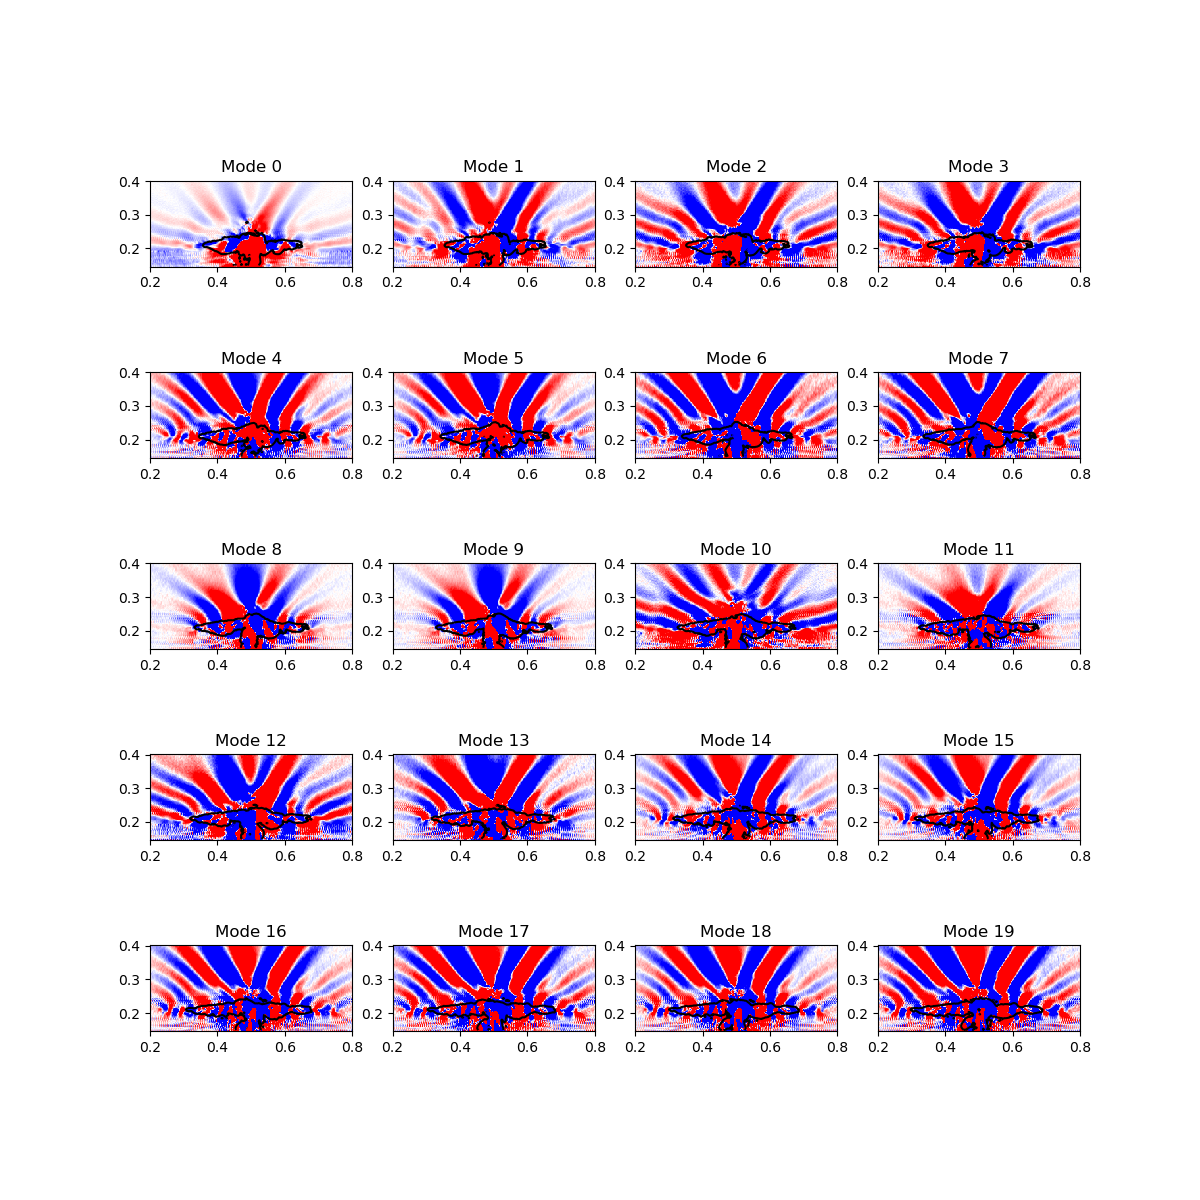

In [8]:
#modes = dmd.modes.reshape((w[0].shape[0], w[0].shape[1], dmd.modes.shape[-1]))
modes = np.moveaxis(dmd.modes, -1, 0)
nmodes = len(modes)

ncol_modes = 4
if nmodes % ncol_modes != 0:
    rnum_modes = nmodes//ncol_modes + 1
else:
    rnum_modes = nmodes//ncol_modes

fig6 = plt.figure(figsize=(12, 12))
for id_subplot, snapshot in enumerate(modes, start=1):
    plt.subplot(rnum_modes, ncol_modes, id_subplot)
    plt.pcolormesh(X, Y, snapshot.reshape(w[0].shape).real, vmin=-clim, vmax=clim, cmap='bwr')
    plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='k')
    plt.xlim(*xlims)
    plt.gca().set_title("Mode {0}".format(id_subplot-1))
    plt.gca().set_aspect(1)

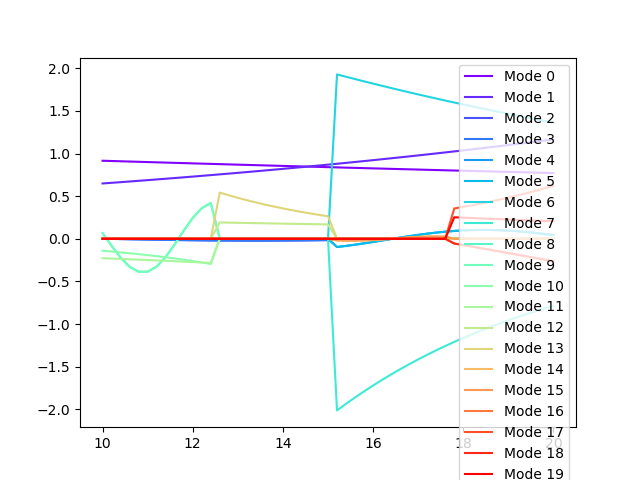

In [9]:
# Plot modes over time
fig7 = plt.figure()
cols = plt.cm.rainbow(np.linspace(0, 1, nmodes))
for n, line in enumerate(dmd.dynamics.real):
    #plt.plot(dmd.dmd_timesteps*md['SAVE_STATS_DT_FINE']*filter_step,
    plt.plot(times, line, label = "Mode {0}".format(n), color=cols[n])

plt.legend()

In [10]:
# Reconstructed data
time_evol = dmd.dynamics
modes = modes.reshape((nmodes, *w[0].shape))
reconstructed = np.zeros_like(snapshots, dtype=np.complex128)
for i in range(len(times)):
    nmodes_r = nmodes
    for j in range(0,nmodes_r):
        reconstructed[i] += time_evol[j,i] * modes[j]
        
reconstructed = np.real(reconstructed)

#reconstructed = dmd.reconstructed_data.T.real.reshape(len(times), *w[0].shape)
print(reconstructed.shape)

(51, 108, 512)
